In [1]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=r"D:\desktop\python\algaenet\dataset\train\images",
    target_size=(71,71),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 700 images belonging to 6 classes.


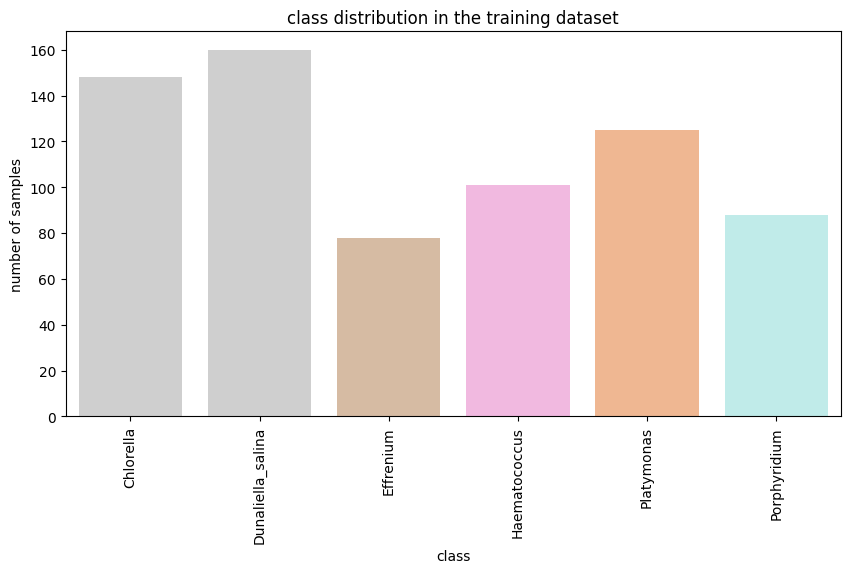

In [3]:
class_indices = train_generator.class_indices

class_names = {v: k for k, v in class_indices.items()}

class_distribution = train_generator.classes

class_names_list = [class_names[class_idx] for class_idx in class_distribution]

plt.figure(figsize=(10, 5))
sns.countplot(x=class_names_list, palette='pastel', order=sorted(class_names_list))
plt.title('class distribution in the training dataset')
plt.xlabel('class')
plt.ylabel('number of samples')
plt.xticks(rotation='vertical')
plt.show()

In [4]:
class_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)

print("class weights")
for class_id, weight in enumerate(class_weights):
    print(f"class- {class_names[class_id]}, weight- {weight}")

class weights
class- Chlorella, weight- 0.7882882882882883
class- Dunaliella_salina, weight- 0.7291666666666666
class- Effrenium, weight- 1.4957264957264957
class- Haematococcus, weight- 1.155115511551155
class- Platymonas, weight- 0.9333333333333333
class- Porphyridium, weight- 1.3257575757575757


In [5]:
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: np.float64(0.7882882882882883),
 1: np.float64(0.7291666666666666),
 2: np.float64(1.4957264957264957),
 3: np.float64(1.155115511551155),
 4: np.float64(0.9333333333333333),
 5: np.float64(1.3257575757575757)}

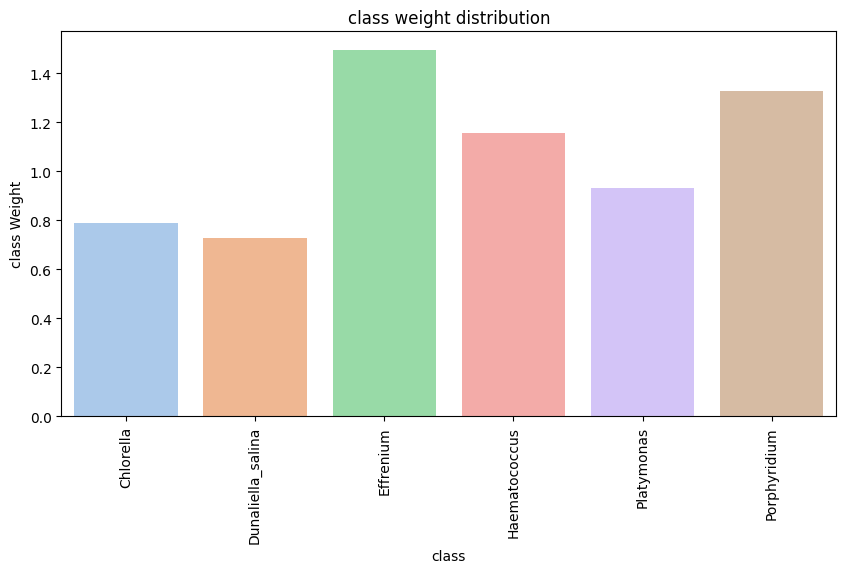

In [6]:
class_weights = [0.78828829, 0.72916667, 1.4957265, 1.15511551, 0.93333333, 1.32575758]
new_class_names = ['Chlorella', 'Dunaliella_salina', 'Effrenium', 'Haematococcus', 'Platymonas', 'Porphyridium']

data = {'Class': new_class_names, 'Weight': class_weights}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Weight', data=df, palette='pastel')
plt.title('class weight distribution')
plt.xlabel('class')
plt.ylabel('class Weight')
plt.xticks(rotation='vertical')
plt.show()

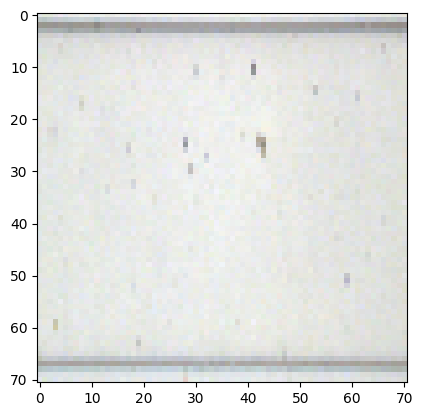

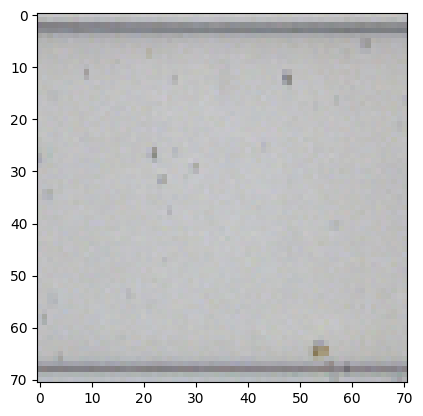

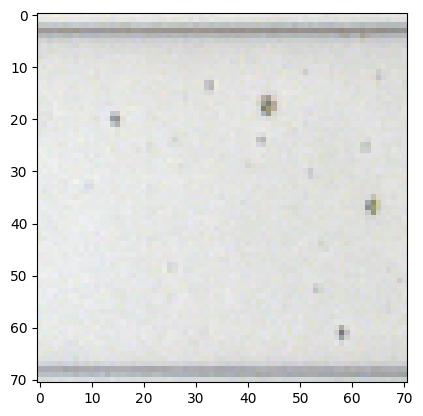

In [7]:
for _ in range(10):
    img, label = next(train_generator)
    if label[0][1] == 1:
        plt.imshow(img[0])
        plt.show()

In [8]:
base_model=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(71, 71, 3),
    pooling=None,
    classes=6,
    classifier_activation="softmax",
)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of b0042744bf5b25fce3cb969f33bebb97 so we will re-download the data.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 651s 8us/step


In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
Xception_learn=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])

In [11]:
Xception_learn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 3, 3, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,566 (81.59 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [12]:
METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), 
]

In [13]:
Xception_learn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'] + METRICS,
)

In [14]:
Xception_history=Xception_learn.fit(train_generator,epochs=100,class_weight=class_weight_dict)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.1633 - auc: 0.5586 - loss: 1.7761 - prc: 0.2002 - precision: 0.4167 - recall: 0.0010   
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2337 - auc: 0.5980 - loss: 1.7236 - prc: 0.2425 - precision: 0.6564 - recall: 0.0107
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.2613 - auc: 0.6515 - loss: 1.6744 - prc: 0.3044 - precision: 0.8275 - recall: 0.0322
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.2898 - auc: 0.6837 - loss: 1.6617 - prc: 0.3261 - precision: 0.7600 - recall: 0.0389
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.3339 - auc: 0.7156 - loss: 1.6711 - prc: 0.3455 - precision: 0.8557 - recall: 0.0357
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.3349 - auc: 0.7329 - loss: 1.6138 - prc: 0.3676 - precision: 0.8311 - recall: 0.0511
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.3521 - auc: 0.7556 - loss: 1.589

In [17]:
df=pd.DataFrame(Xception_history.history)
df.to_csv("xception_plot.csv",index=False)

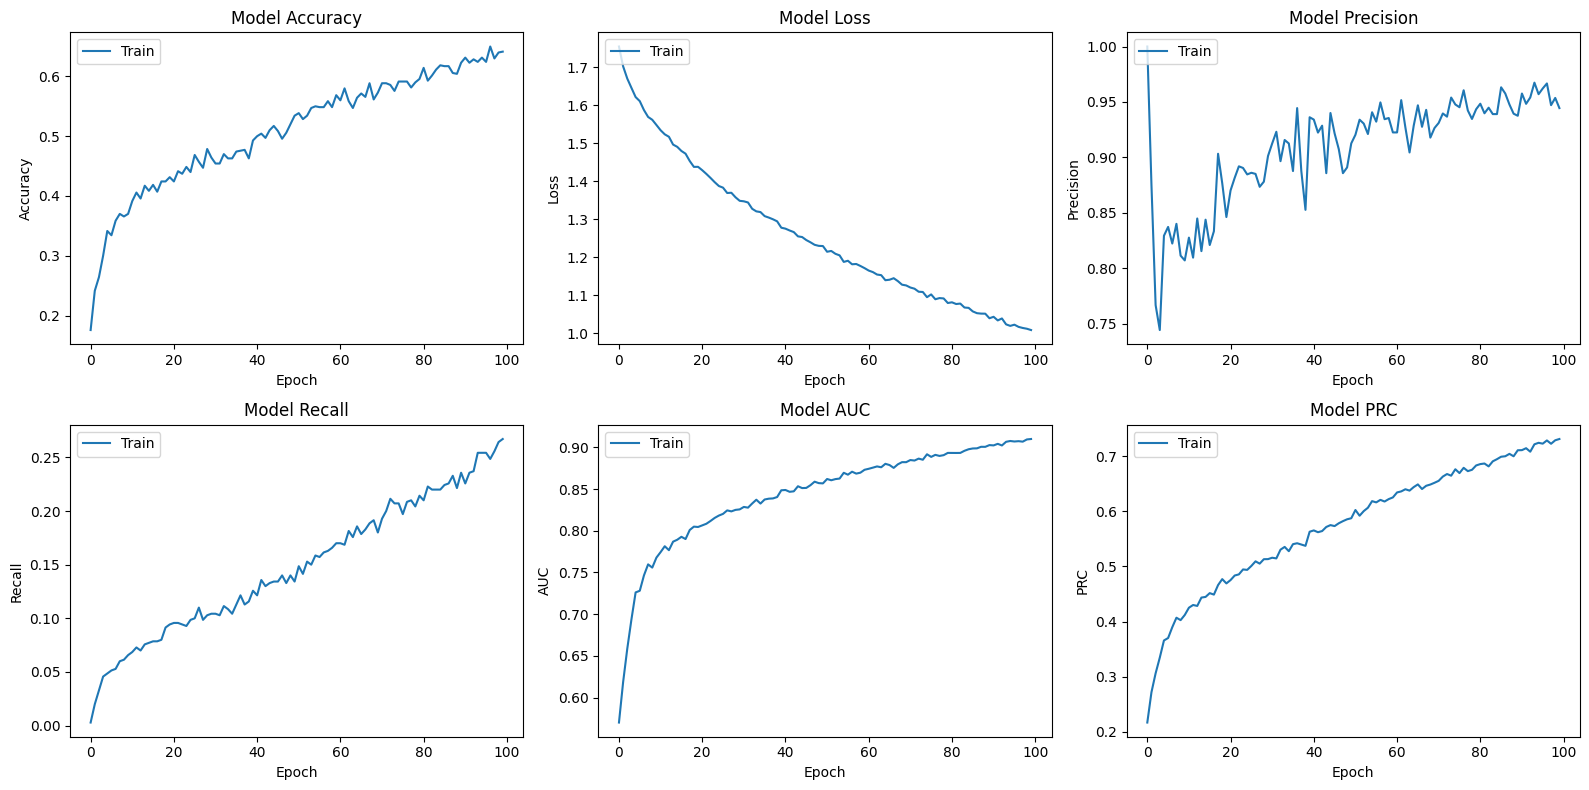

In [15]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.plot(Xception_history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

plt.subplot(2, 3, 2)
plt.plot(Xception_history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

plt.subplot(2, 3, 3)
plt.plot(Xception_history.history['precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train'], loc='upper left')

plt.subplot(2, 3, 4)
plt.plot(Xception_history.history['recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train'], loc='upper left')

plt.subplot(2, 3, 5)
plt.plot(Xception_history.history['auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train'], loc='upper left')

plt.subplot(2, 3, 6)
plt.plot(Xception_history.history['prc'])
plt.title('Model PRC')
plt.xlabel('Epoch')
plt.ylabel('PRC')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()